Based on Kaggle python3 docker image.
For more explaintation:
https://www.kaggle.com/junxiangji/lstm-sentiment-analysis-keras/edit 


# TODO - What do we learn from the work

This can be further tweaked by 
* ~~remove @someone in the tweets.~~
* remove stop words.
* make it support Chinese.
* use word2vec during embeding.
* change the LSTM to TextCNN ro FastText and change the parameter.
* give emoticons more importance.
* ~~Boosting - Observed that having an extra `neutral` category would greatly decrease `positive` acc (much worse than randomly perdition which should have 30% acc) and predition for neutral is as bad as random perdiction. We need to only train the model for `positive` and `neutral` and then ensamble them togather.~~
    - The second model cannot tell difference between Positive and Neutral.
* also considering that the train accuracy is high and has huge diverse with test result, we are having great overfit problem here.
    - TODO - Need to prove this by using all data to train and some of the USED data to test, the test
* Considering that positive has 2000 tweets at 10% acc and netural has 3000 tweets at 36% acc, we might conclude that number of cropus is top 1 factor which affects the accuracy. ** so we should consider to give more data to training when split the data to trian and test.(currently .33 suggest to .10) **
* data set is highly imbalanced that would make the model prone to perdict everything as negitive (in every mini batch). Try to duplicate the _neutral_ by 2 times and _negtive_ by 4 times. (This may not need if we use above boosting method.)
* ~~read more paper regarding this LSTM model.~~
    - Using BiLSTM


### In this version we will first train model1 for Negative and the rest, then train model for Netural and Positive, then ensemble two models togather.

In [303]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [304]:
data1 = pd.read_csv('./data/Sentiment.csv')
# Keeping only the neccessary columns
data = data1[['text','sentiment']]

In [305]:
%matplotlib inline
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
data[0:9]
# data.dtypes

# data[data.sentiment.isnull()]

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",Positive
6,RT @warriorwoman91: I liked her and was happy ...,Negative
7,Going on #MSNBC Live with @ThomasARoberts arou...,Neutral
8,Deer in the headlights RT @lizzwinstead: Ben C...,Negative


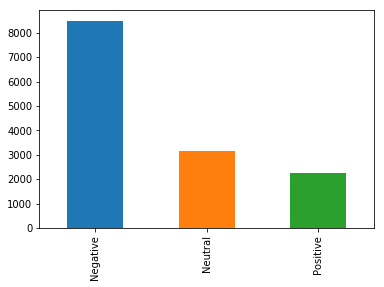

In [306]:
data.sentiment.value_counts().plot(kind="bar")

In [307]:
# Common process of the data

# replace the named entities
data['text'] = data['text'].apply((lambda x: re.sub('@.*?\s', 'somebody ', x)))
data['text'] = data['text'].apply((lambda x: re.sub('\#.*?\s', 'something ', x)))

data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].shape)
print(data[ data['sentiment'] == 'Negative'].shape)
print(data[ data['sentiment'] == 'Neutral'].shape)

print("data shape: ", data.shape)
#print(data.tail)
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

(2236, 2)
(8493, 2)
(3142, 2)
data shape:  (13871, 2)


In [308]:
'''
For Model 2:
Only train for the neutral and positive.
'''
data_for_model_2 = data.copy()

data_for_model_2 = data_for_model_2[data_for_model_2.sentiment != "Negative"]

data_for_model_2[0:9]

print("model2 data size: ", data_for_model_2.shape)

'''
For final validation
'''
data_for_ens = data.copy()



'\nFor Model 2:\nOnly train for the neutral and positive.\n'

,text,sentiment
0,somebody how did everyone feel about the cli...,Neutral
1,somebody didnt catch the full something last...,Positive
2,somebody no mention of tamir rice and the so...,Neutral
3,somebody that carly fiorina is trending hou...,Positive
4,somebody something w somebody delivered the ...,Positive
5,somebody somebody on my first day i will res...,Positive
7,going on something live with somebody around 2...,Neutral
11,somebody just woke up to tweet this out some...,Positive
13,somebody somebody dear somebody something ...,Neutral


model2 data size:  (5378, 2)


'\nFor final validation\n'

In [309]:
'''
For model 1:
Previously we have Positive, Netural, Negative. Here we mark the Neutral to Positive. 
So only Positive and Negative left.
'''

data.loc[data.sentiment == "Neutral", 'sentiment'] = 'Positive'
data[0:9]

'\nFor model 1:\nPreviously we have Positive, Netural, Negative. Here we mark the Neutral to Positive. \nSo only Positive and Negative left.\n'

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,text,sentiment
0,somebody how did everyone feel about the cli...,Positive
1,somebody didnt catch the full something last...,Positive
2,somebody no mention of tamir rice and the so...,Positive
3,somebody that carly fiorina is trending hou...,Positive
4,somebody something w somebody delivered the ...,Positive
5,somebody somebody on my first day i will res...,Positive
6,somebody i liked her and was happy when i he...,Negative
7,going on something live with somebody around 2...,Positive
8,deer in the headlights somebody ben carson m...,Negative


In [310]:
'''For model 1'''
    
max_fatures = 4000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
#tokenizer.word_counts
# tokenizer.word_index # index started from 1 not 0.
X[0:2] # type is list
data[0:9]

'''For model 2'''

tokenizer2 = Tokenizer(num_words=max_fatures, split=' ')
tokenizer2.fit_on_texts(data_for_model_2['text'].values)

X2 = tokenizer.texts_to_sequences(data_for_model_2['text'].values)
#tokenizer.word_counts
# tokenizer.word_index # index started from 1 not 0.
X2[0:2] # type is list


'For model 1'

[[2, 50, 75, 320, 426, 23, 3, 393, 343, 93, 29, 49, 947, 11],
 [2,
  120,
  1746,
  3,
  556,
  1,
  29,
  49,
  221,
  35,
  189,
  5,
  168,
  1280,
  12,
  1428,
  1221,
  1]]

,text,sentiment
0,somebody how did everyone feel about the cli...,Positive
1,somebody didnt catch the full something last...,Positive
2,somebody no mention of tamir rice and the so...,Positive
3,somebody that carly fiorina is trending hou...,Positive
4,somebody something w somebody delivered the ...,Positive
5,somebody somebody on my first day i will res...,Positive
6,somebody i liked her and was happy when i he...,Negative
7,going on something live with somebody around 2...,Positive
8,deer in the headlights somebody ben carson m...,Negative


'For model 2'

[[2, 50, 75, 320, 426, 23, 3, 393, 343, 93, 29, 49, 947, 11],
 [2,
  120,
  1746,
  3,
  556,
  1,
  29,
  49,
  221,
  35,
  189,
  5,
  168,
  1280,
  12,
  1428,
  1221,
  1]]

In [311]:
 # type is array and we prefixed with zeros. This should be masked in model
X = pad_sequences(X)
X2 = pad_sequences(X2)
print("X shape", X.shape)
print("X2 shape", X2.shape)
X[0:2]

X shape (13871, 29)
X2 shape (5378, 29)


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    2,   50,   75,  320,  426,   23,    3,
         393,  343,   93,   29,   49,  947,   11],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           2,  120, 1746,    3,  556,    1,   29,   49,  221,   35,  189,
           5,  168, 1280,   12, 1428, 1221,    1]], dtype=int32)

# Embeding and Define Model
For the following Embeding layer. The input is the sequence of words, and the out put will has one more dimension.
Which is because now one word previously is represented as a number now become a vector (word embeding)

Ref
https://stackoverflow.com/questions/46155868/keras-embedding-layer

https://keras.io/layers/embeddings/

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [312]:
''' Model 1 '''

embed_dim = 128
lstm_out = 196

model1 = Sequential()

# zeros are paddings and thus need mask
model1.add(Embedding(max_fatures, embed_dim, mask_zero="Ture", input_length = X.shape[1]))
model1.add(SpatialDropout1D(0.1)) # TODO need to understand details of this dropout.
model1.add(Bidirectional(LSTM(lstm_out, dropout=0.3, recurrent_dropout=0.2)))
model1.add(Dense(2,activation='softmax'))
model1.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model1.summary())

''' Model 2 '''

model2 = Sequential()

model2.add(Embedding(max_fatures, embed_dim,mask_zero="Ture", input_length = X2.shape[1]))
model2.add(SpatialDropout1D(0.1))
model2.add(Bidirectional(LSTM(lstm_out, dropout=0.3, recurrent_dropout=0.2)))
model2.add(Dense(2,activation='softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model2.summary())

' Model 1 '

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 29, 128)           512000    
_________________________________________________________________
spatial_dropout1d_23 (Spatia (None, 29, 128)           0         
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 392)               509600    
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 786       
Total params: 1,022,386
Trainable params: 1,022,386
Non-trainable params: 0
_________________________________________________________________
None


' Model 2 '

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 29, 128)           512000    
_________________________________________________________________
spatial_dropout1d_24 (Spatia (None, 29, 128)           0         
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 392)               509600    
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 786       
Total params: 1,022,386
Trainable params: 1,022,386
Non-trainable params: 0
_________________________________________________________________
None


In [313]:
# negetive, neutral, pos for origional data.

Y = pd.get_dummies(data['sentiment']).values
Y # [Negative, Positive]

Y2 = pd.get_dummies(data_for_model_2['sentiment']).values
Y2 # [Neutral, Positive]

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]], dtype=uint8)

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [314]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2,Y2, test_size = 0.15, random_state = 42)
'''model 1'''
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
'''model 2'''
print(X2_train.shape,Y2_train.shape)
print(X2_test.shape,Y2_test.shape)

'model 1'

(11790, 29) (11790, 2)
(2081, 29) (2081, 2)


'model 2'

(4571, 29) (4571, 2)
(807, 29) (807, 2)


# Train Model

In [315]:
batch_size = 32
model1.fit(X_train, Y_train, epochs = 8, batch_size=batch_size, verbose = 2)
model2.fit(X2_train, Y2_train, epochs = 8, batch_size=batch_size, verbose = 2)

Epoch 1/8
 - 76s - loss: 0.5705 - acc: 0.6982
Epoch 2/8
 - 61s - loss: 0.4747 - acc: 0.7716
Epoch 3/8
 - 55s - loss: 0.4116 - acc: 0.8108
Epoch 4/8
 - 55s - loss: 0.3593 - acc: 0.8405
Epoch 5/8
 - 55s - loss: 0.3201 - acc: 0.8595
Epoch 6/8
 - 55s - loss: 0.2803 - acc: 0.8835
Epoch 7/8
 - 55s - loss: 0.2549 - acc: 0.8919
Epoch 8/8
 - 56s - loss: 0.2283 - acc: 0.9028


Epoch 1/8
 - 29s - loss: 0.6157 - acc: 0.6697
Epoch 2/8
 - 21s - loss: 0.4571 - acc: 0.7928
Epoch 3/8
 - 22s - loss: 0.3532 - acc: 0.8477
Epoch 4/8
 - 22s - loss: 0.2792 - acc: 0.8865
Epoch 5/8
 - 21s - loss: 0.2263 - acc: 0.9112
Epoch 6/8
 - 21s - loss: 0.2005 - acc: 0.9263
Epoch 7/8
 - 22s - loss: 0.1818 - acc: 0.9313
Epoch 8/8
 - 21s - loss: 0.1653 - acc: 0.9377


# Training Score
## Pure LSTM
Epoch 10/100
 - 18s - loss: 0.4684 - acc: 0.8115
 
## Ensemble 
** model 1 **

Epoch 8/8
 - 62s - loss: 0.2663 - acc: 0.8882
 
** model 2 **

 Epoch 8/8
 - 25s - loss: 0.2021 - acc: 0.9212

In [316]:

model1.save('ensemble1.h5')
model2.save('ensemble2.h5')

In [317]:
from keras.models import load_model
model1 = load_model('ensemble1.h5')
model2 = load_model('ensemble2.h5')

# Test Score

In [318]:
'''model 1 '''

score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

'''model 2 '''

score2,acc2 = model.evaluate(X2_test, Y2_test, verbose = 2, batch_size = batch_size)
print("score2: %.2f" % (score2))
print("acc2: %.2f" % (acc2))

'model 1 '

score: 0.89
acc: 0.72


'model 2 '

score2: 1.86
acc2: 0.51


# Score
## Pure LSTM
pos_acc 10.129870129870131 %
neu_acc 36.811594202898554 %
neg_acc 79.27232635060639 %
## Bi LSTM
pos_acc 10.179640718562874 %
neu_acc 40.78549848942598 %
neg_acc 80.08519701810437 %
## Ensemble
'model 1 '

score: 0.89
acc: 0.72

'model 2 '

score2: 1.86
acc2: 0.51

# Prediction

In [327]:
# twt = ['Meetings: Because none of us is as dumb as all of us.']
# twt = ['good']
twt = ['I dont like him']
# twt = ['not bad']

'''
BiLSTM can differenciate the 'good' and 'no good'.
'''

#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=29, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]

print(model.predict_proba(twt,batch_size=1,verbose = 2))

# [Negative, Other] [Neutral, Positive]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(model2.predict(twt,batch_size=1,verbose = 2)[0]) == 0):
    print("neutral")
else:
    print("positive")

print("\n >> Perdict Performance")
%timeit model.predict(twt,batch_size=1,verbose = 2)

"\nBiLSTM can differenciate the 'good' and 'no good'.\n"

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0 10 48 42 78]]
[[0.5349576  0.46504244]]
negative

 >> Perdict Performance
8.4 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
